# Kohonen

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import os
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import matplotlib.patches as patches
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans

class KohonenNetwork:
    def __init__(self, input_dim, grid_size=(10, 10), neighborhood_function='gaussian', 
                 neighborhood_width=1.0, learning_rate_decay=1000, topology='rectangular'):
        self.input_dim = input_dim
        self.grid_size = grid_size
        self.M, self.N = grid_size
        self.topology = topology
        
        if topology == 'rectangular':
            self.weights = np.random.rand(self.M, self.N, input_dim)
        elif topology == 'hexagonal':
            self.weights = np.random.rand(self.M, self.N, input_dim)
        else:
            raise ValueError("Topologia musi być 'rectangular' lub 'hexagonal'")
        
        if neighborhood_function == 'gaussian':
            self.neighborhood_function = self._gaussian
        elif neighborhood_function == 'mexican_hat':
            self.neighborhood_function = self._mexican_hat
        else:
            raise ValueError("Funkcja sąsiedztwa musi być 'gaussian' lub 'mexican_hat'")
        
        self.neighborhood_width = neighborhood_width
        self.learning_rate_decay = learning_rate_decay
        
        self._initialize_neuron_positions()
    
    def _initialize_neuron_positions(self):
        if self.topology == 'rectangular':
            self.neuron_positions = np.array([[(i, j) for j in range(self.N)] for i in range(self.M)]) # siatka prostokątna
        elif self.topology == 'hexagonal':
            self.neuron_positions = np.zeros((self.M, self.N, 2))
            for i in range(self.M):
                for j in range(self.N):
                    if i % 2 == 0:
                        self.neuron_positions[i, j] = [i * np.sqrt(3)/2, j]
                    else:
                        self.neuron_positions[i, j] = [i * np.sqrt(3)/2, j + 0.5]
    
    def _gaussian(self, distance, t):
        sigma0 = self.neighborhood_width
        tau    = self.learning_rate_decay
        sigma = sigma0 * np.exp(-t / tau)
        return np.exp(-(distance ** 2) / (2 * sigma ** 2))


    def _mexican_hat(self, distance, t):
        sigma0 = self.neighborhood_width
        tau    = self.learning_rate_decay
        sigma  = sigma0 * np.exp(-t / tau)
        dist2 = distance ** 2
        factor = dist2 / (sigma ** 2)
        return (1 - factor) * np.exp(-dist2 / (2 * sigma ** 2))

    
    def _learning_rate(self, t):
        return np.exp(-t / self.learning_rate_decay)
    
    def _calculate_distances(self, bmu):
        if self.topology == 'rectangular':
            grid_dist = np.sum((self.neuron_positions - np.array(bmu)) ** 2, axis=2) ** 0.5
        elif self.topology == 'hexagonal':
            bmu_pos = self.neuron_positions[bmu[0], bmu[1]]
            distances = np.zeros((self.M, self.N))
            for i in range(self.M):
                for j in range(self.N):
                    distances[i, j] = np.linalg.norm(self.neuron_positions[i, j] - bmu_pos)
            grid_dist = distances
        return grid_dist
    
    def _find_bmu(self, x):
        distances = np.sum((self.weights - x) ** 2, axis=2)
        bmu_idx = np.unravel_index(np.argmin(distances), distances.shape)
        return bmu_idx
    
    def train(self, data, epochs=100, verbose=True):
        n_samples = data.shape[0]
        for epoch in tqdm(range(epochs), desc="Trening sieci", unit="epoka"):
            indices = np.random.permutation(n_samples)
            for idx in indices:
                x = data[idx]
                bmu = self._find_bmu(x)
                grid_dist = self._calculate_distances(bmu)
                learning_rate = self._learning_rate(epoch)
                neighborhood = self.neighborhood_function(grid_dist, epoch)
                update = learning_rate * neighborhood[:, :, np.newaxis] * (x - self.weights)
                self.weights += update
    
    def map_input(self, x):
        return self._find_bmu(x)
    
    def get_mapped_data(self, data):
        return np.array([self.map_input(x) for x in data])

    def get_cluster_labels(self, data):
        bmu_indices = self.get_mapped_data(data)
        cluster_labels = np.array([i * self.N + j for i, j in bmu_indices])
        return cluster_labels
    
    def calculate_silhouette_score(self, data, cluster_labels=None):
        if cluster_labels is None:
            cluster_labels = self.get_cluster_labels(data)
            
        unique_clusters = np.unique(cluster_labels)
        
        if len(unique_clusters) < 2:
            return {
                'silhouette_score': None,
                'silhouette_samples': None,
                'error': 'Need at least 2 clusters for silhouette score calculation'
            }
        try:
            sil_score = silhouette_score(data, cluster_labels)
            sil_samples = silhouette_samples(data, cluster_labels)
            
            return {
                'silhouette_score': sil_score,
                'silhouette_samples': sil_samples,
                'error': None
            }
        except Exception as e:
            return {
                'silhouette_score': None,
                'silhouette_samples': None,
                'error': str(e)
            }
    
    def visualize_silhouette(self, data, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))
        cluster_labels = self.get_cluster_labels(data)
        silhouette_result = self.calculate_silhouette_score(data, cluster_labels)
        
        if silhouette_result['error'] is not None:
            ax.text(0.5, 0.5, f"Error: {silhouette_result['error']}", 
                    ha='center', va='center', transform=ax.transAxes)
            return ax
            
        sil_samples = silhouette_result['silhouette_samples']
        unique_clusters = np.unique(cluster_labels)
        n_clusters = len(unique_clusters)
        y_lower = 10
        cmap = plt.cm.get_cmap('viridis', n_clusters)
        
        for i, cluster in enumerate(unique_clusters):
            ith_cluster_sil_values = sil_samples[cluster_labels == cluster]
            ith_cluster_sil_values.sort()
            cluster_size = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + cluster_size
            color = cmap(i / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values,
                             facecolor=color, edgecolor=color, alpha=0.7)
            ax.text(-0.05, y_lower + 0.5 * cluster_size, str(cluster))
            y_lower = y_upper + 10
        ax.axvline(x=silhouette_result['silhouette_score'], color="red", linestyle="--")
        
        ax.set_title(f"Silhouette Plot (Score: {silhouette_result['silhouette_score']:.3f})")
        ax.set_xlabel("Silhouette Coefficient Values")
        ax.set_ylabel("Cluster Label")
        ax.set_yticks([])
        ax.set_xlim([-0.1, 1])
        
        return ax
    
    def visualize_map(self, data=None, labels=None, title="Siec Kohonena", ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 8))
        if self.topology == 'hexagonal':
            self._visualize_hexagonal_map(data, labels, title, ax)
        else:
            self._visualize_rectangular_map(data, labels, title, ax)
        return ax
    
    def _visualize_rectangular_map(self, data, labels, title, ax):
        if data is not None and labels is not None:
            mapped_data = self.get_mapped_data(data)
            unique_labels = np.unique(labels)
            grid_labels = np.zeros((self.M, self.N))
            grid_counts = np.zeros((self.M, self.N))
            
            for data_idx, (i, j) in enumerate(mapped_data):
                label = labels[data_idx]
                grid_labels[i, j] += label
                grid_counts[i, j] += 1
            
            neuron_classes = np.zeros((self.M, self.N))
            for i in range(self.M):
                for j in range(self.N):
                    if grid_counts[i, j] > 0:
                        neuron_classes[i, j] = grid_labels[i, j] / grid_counts[i, j]
                    else:
                        neuron_classes[i, j] = -1
            
            cmap = plt.cm.get_cmap('viridis', len(unique_labels))
            masked_data = np.ma.masked_where(grid_counts == 0, neuron_classes)
            im = ax.imshow(masked_data, cmap=cmap, interpolation='nearest', 
                          vmin=np.min(unique_labels), vmax=np.max(unique_labels))
            
            for i in range(self.M):
                for j in range(self.N):
                    if grid_counts[i, j] > 0:
                        ax.text(j, i, str(int(grid_counts[i, j])), 
                               ha="center", va="center", color="white", fontsize=8)
            
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label("Dominująca klasa")
            
            for i in range(self.M + 1):
                ax.axhline(i - 0.5, color='k', linestyle='-', alpha=0.3)
            for j in range(self.N + 1):
                ax.axvline(j - 0.5, color='k', linestyle='-', alpha=0.3)
        else:
            for i in range(self.M):
                for j in range(self.N):
                    ax.plot(j, i, 'ko', markersize=8)
            
            for i in range(self.M):
                for j in range(self.N):
                    if i < self.M - 1:
                        ax.plot([j, j], [i, i+1], 'k-', alpha=0.3)
                    if j < self.N - 1:
                        ax.plot([j, j+1], [i, i], 'k-', alpha=0.3)
        
        ax.set_title(title)
        ax.set_xlim(-0.5, self.N - 0.5)
        ax.set_ylim(self.M - 0.5, -0.5)
        ax.set_aspect('equal')
        
        ax.set_xlabel("Kolumna neuronu")
        ax.set_ylabel("Wiersz neuronu")
    
    def _visualize_hexagonal_map(self, data, labels, title, ax):
        neuron_info = {}
        if data is not None and labels is not None:
            if not isinstance(labels, np.ndarray):
                labels = np.array(labels)
            mapped_data = self.get_mapped_data(data)
            unique_labels = np.unique(labels)
            
            for i in range(self.M):
                for j in range(self.N):
                    neuron_info[(i, j)] = {'counts': {label: 0 for label in unique_labels}, 
                                        'total': 0, 
                                        'dominant_class': None,
                                        'purity': 0.0}
            
            for data_idx, (i, j) in enumerate(mapped_data):
                label = labels[data_idx]
                neuron_info[(i, j)]['counts'][label] += 1
                neuron_info[(i, j)]['total'] += 1
            
            for pos, info in neuron_info.items():
                if info['total'] > 0:
                    dominant_class = max(info['counts'].items(), key=lambda x: x[1])[0]
                    info['dominant_class'] = dominant_class
                    info['purity'] = info['counts'][dominant_class] / info['total']
            
            cmap = plt.cm.get_cmap('viridis', len(unique_labels))
        
        hex_size = 0.4
        angles = np.linspace(0, 2*np.pi, 7)
        
        for i in range(self.M):
            for j in range(self.N):
                center = self.neuron_positions[i, j]
                
                hex_x = center[1] + hex_size * np.cos(angles)
                hex_y = center[0] + hex_size * np.sin(angles)
                hex_vertices = list(zip(hex_x, hex_y))
                
                if data is not None and labels is not None:
                    info = neuron_info[(i, j)]
                    
                    if info['total'] > 0:
                        color_idx = info['dominant_class'] / max(unique_labels)
                        color = cmap(color_idx)
                        
                        alpha = max(0.3, info['purity'])
                        
                        hex_patch = patches.Polygon(hex_vertices, 
                                                facecolor=color, 
                                                edgecolor='black', 
                                                alpha=alpha,
                                                linewidth=1)
                        
                        ax.text(center[1], center[0], str(info['total']), 
                            ha="center", va="center", 
                            color="white", fontsize=8, fontweight='bold')
                    else:
                        hex_patch = patches.Polygon(hex_vertices, 
                                                facecolor='white', 
                                                edgecolor='black', 
                                                alpha=0.3,
                                                linewidth=0.5)
                else:
                    hex_patch = patches.Polygon(hex_vertices, 
                                            facecolor='white', 
                                            edgecolor='black', 
                                            alpha=0.7,
                                            linewidth=0.5)
                ax.add_patch(hex_patch)
        if data is not None and labels is not None:
            sm = plt.cm.ScalarMappable(cmap=cmap, 
                                    norm=plt.Normalize(vmin=min(unique_labels), 
                                                        vmax=max(unique_labels)))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax)
            cbar.set_label("Dominująca klasa")
        
        ax.set_title(title)
        ax.set_aspect('equal')
        ax.set_xlim(np.min(self.neuron_positions[:, :, 1]) - hex_size - 0.5, 
                np.max(self.neuron_positions[:, :, 1]) + hex_size + 0.5)
        ax.set_ylim(np.min(self.neuron_positions[:, :, 0]) - hex_size - 0.5, 
                np.max(self.neuron_positions[:, :, 0]) + hex_size + 0.5)
        ax.axis('off')
    
    def analyze_clustering(self, data, labels):
        mapped_data = self.get_mapped_data(data)
        unique_labels = np.unique(labels)
        neuron_class_counts = {}
        
        for i in range(self.M):
            for j in range(self.N):
                neuron_class_counts[(i, j)] = {label: 0 for label in unique_labels}
        
        for data_idx, (i, j) in enumerate(mapped_data):
            label = labels[data_idx]
            neuron_class_counts[(i, j)][label] += 1
        
        neurons_with_mixed_classes = 0
        neurons_with_data = 0
        
        for (i, j), class_counts in neuron_class_counts.items():
            if sum(class_counts.values()) > 0:
                neurons_with_data += 1
                classes_in_neuron = sum(1 for count in class_counts.values() if count > 0)
                if classes_in_neuron > 1:
                    neurons_with_mixed_classes += 1
        
        neuron_coords = []
        for (i, j), class_counts in neuron_class_counts.items():
            if sum(class_counts.values()) > 0:
                neuron_coords.append((i, j))
        
        if not neuron_coords:
            clusters = []
        else:
            neuron_coords = np.array(neuron_coords)
            visited = set()
            clusters = []
            
            for idx, (i, j) in enumerate(neuron_coords):
                if (i, j) in visited:
                    continue
                
                cluster = [(i, j)]
                visited.add((i, j))
                
                stack = [(i, j)]
                while stack:
                    x, y = stack.pop()
                    neighbors = self._get_neighbors(x, y)
                    
                    for nx, ny in neighbors:
                        if (nx, ny) in neuron_class_counts and (nx, ny) not in visited:
                            if sum(neuron_class_counts[(nx, ny)].values()) > 0:
                                cluster.append((nx, ny))
                                visited.add((nx, ny))
                                stack.append((nx, ny))
                
                clusters.append(cluster)
        
        clusters_match_classes = len(clusters) == len(unique_labels)
        
        class_positions = {label: np.zeros(2) for label in unique_labels}
        class_counts = {label: 0 for label in unique_labels}
        
        for data_idx, (i, j) in enumerate(mapped_data):
            label = labels[data_idx]
            if self.topology == 'hexagonal':
                class_positions[label] += self.neuron_positions[i, j]
            else:
                class_positions[label] += np.array([i, j])
            class_counts[label] += 1
        
        for label in unique_labels:
            if class_counts[label] > 0:
                class_positions[label] /= class_counts[label]
        
        neuron_stats = {}
        for (i, j), class_counts in neuron_class_counts.items():
            total = sum(class_counts.values())
            if total > 0:
                dominant_class = max(class_counts.items(), key=lambda x: x[1])[0]
                purity = class_counts[dominant_class] / total
                neuron_stats[(i, j)] = {
                    'total_samples': total,
                    'class_counts': class_counts,
                    'dominant_class': dominant_class,
                    'purity': purity
                }
        
        silhouette_results = self.calculate_silhouette_score(data)
        
        return {
            'num_clusters': len(clusters),
            'num_classes': len(unique_labels),
            'clusters_match_classes': clusters_match_classes,
            'neurons_with_mixed_classes': neurons_with_mixed_classes,
            'neurons_with_data': neurons_with_data,
            'mixed_classes_percentage': neurons_with_mixed_classes / neurons_with_data if neurons_with_data > 0 else 0,
            'class_positions': class_positions,
            'neuron_stats': neuron_stats,
            'clusters': clusters,
            'silhouette_score': silhouette_results.get('silhouette_score', None),
            'silhouette_error': silhouette_results.get('error', None)
        }
    
    def _get_neighbors(self, i, j):
        """Znajdź sąsiadów neuronu w zależności od topologii"""
        if self.topology == 'rectangular':
            return [(i+1, j), (i-1, j), (i, j+1), (i, j-1)]
        elif self.topology == 'hexagonal':
            if i % 2 == 0:  # Parzyste wiersze
                neighbors = [
                    (i-1, j-1), (i-1, j),   # Górzy sąsiedzi
                    (i, j-1), (i, j+1),     # Boczni sąsiedzi
                    (i+1, j-1), (i+1, j)    # Dolni sąsiedzi
                ]
            else:  # Nieparzyste wiersze
                neighbors = [
                    (i-1, j), (i-1, j+1),   # Górzy sąsiedzi
                    (i, j-1), (i, j+1),     # Boczni sąsiedzi
                    (i+1, j), (i+1, j+1)    # Dolni sąsiedzi
                ]
            
            # Filtruj sąsiadów, aby pozostali w granicach siatki
            valid_neighbors = []
            for ni, nj in neighbors:
                if 0 <= ni < self.M and 0 <= nj < self.N:
                    valid_neighbors.append((ni, nj))
            return valid_neighbors
    
    def visualize_weight_planes(self, ax=None):
        if ax is None:
            nrows = int(np.ceil(self.input_dim / 2))
            fig, axes = plt.subplots(nrows, 2, figsize=(12, 3 * nrows))
            axes = axes.flatten()
        else:
            nrows = int(np.ceil(self.input_dim / 2))
            ncols = 2
            if self.input_dim == 1:
                axes = [ax]
            else:
                axes = np.array(ax).flatten()
        
        for i in range(self.input_dim):
            if i < len(axes):
                weight_plane = self.weights[:, :, i]
                im = axes[i].imshow(weight_plane, cmap='viridis', interpolation='nearest')
                axes[i].set_title(f"Wymiar {i+1}")
                plt.colorbar(im, ax=axes[i])
                
                for row in range(self.M + 1):
                    axes[i].axhline(row - 0.5, color='k', linestyle='-', alpha=0.3)
                for col in range(self.N + 1):
                    axes[i].axvline(col - 0.5, color='k', linestyle='-', alpha=0.3)
        
        if ax is None:
            for i in range(self.input_dim, len(axes)):
                axes[i].axis('off')
            
            plt.tight_layout()
        return axes

# Data

## Loaders

### KOH 1

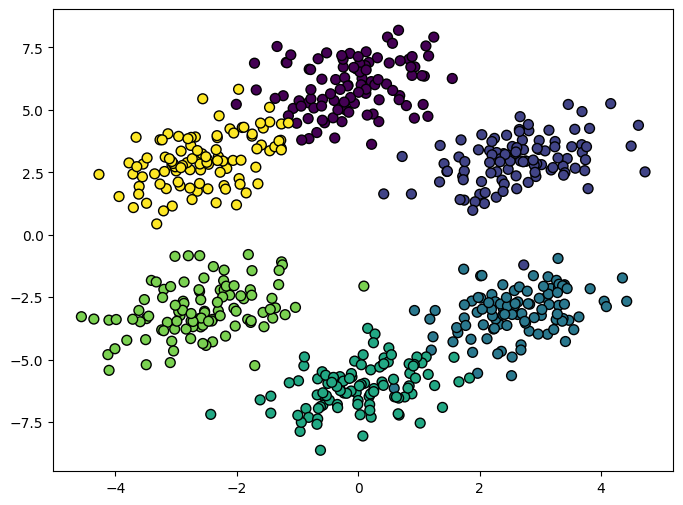

In [15]:
hexagon_path = "data/hexagon.csv"
data = pd.read_csv(hexagon_path, header=1).values
classes = data[:, 2]
data = data[:, :2]

# plot
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=classes, cmap='viridis', edgecolor='k', s=50)

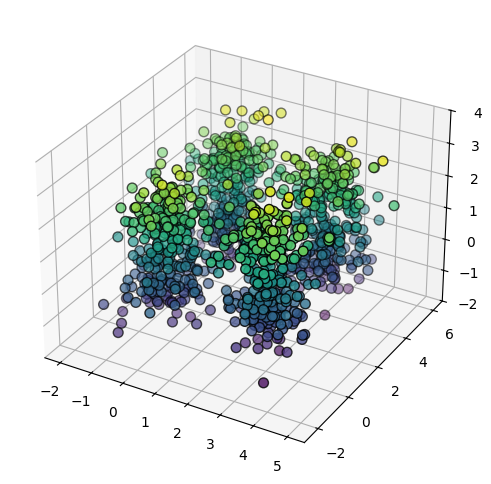

In [19]:
cube_path = "data/cube.csv"
data = pd.read_csv(cube_path, header=1).values
classes = data[:, 2]
data = data[:, :3]
plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=classes, cmap='viridis', edgecolor='k', s=50)

#### Analiza Clustrow

In [5]:
def analyze_som_clustering(data, labels=None, max_clusters=10, grid_size=(4, 4)):
    print(f"Training SOM with fixed grid size {grid_size[0]}x{grid_size[1]}...")
    som = KohonenNetwork(input_dim=data.shape[1], grid_size=grid_size,
                       topology='hexagonal', neighborhood_function='gaussian')
    som.train(data, epochs=100)
    
    mapped_data = som.get_mapped_data(data)
    som_labels = np.array([i * grid_size[1] + j for i, j in mapped_data])
    silhouette_scores = []
    cluster_sizes = range(2, max_clusters+1)
    
    for n_clusters in cluster_sizes:
        print(f"Evaluating with {n_clusters} clusters...")
        unique_neurons = np.unique(mapped_data, axis=0)
        neuron_weights = np.array([som.weights[i, j] for i, j in unique_neurons])
        
        if len(unique_neurons) < n_clusters:
            print(f"  Warning: Only {len(unique_neurons)} unique neurons activated, can't create {n_clusters} clusters")
            silhouette_scores.append(float('nan'))
            continue
            
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        neuron_clusters = kmeans.fit_predict(neuron_weights)
        
        data_clusters = np.zeros(len(data), dtype=int)
        for idx, (i, j) in enumerate(mapped_data):
            neuron_idx = np.where((unique_neurons == [i, j]).all(axis=1))[0][0]
            data_clusters[idx] = neuron_clusters[neuron_idx]
        
        try:
            score = silhouette_score(data, data_clusters)
            silhouette_scores.append(float(score))
            print(f"  Silhouette score: {score:.3f}")
        except Exception as e:
            print(f"  Error calculating silhouette score: {e}")
            silhouette_scores.append(float('nan'))
    
    return cluster_sizes, silhouette_scores

Training SOM with fixed grid size 10x10...


Trening sieci: 100%|██████████| 100/100 [00:23<00:00,  4.28epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.576
Evaluating with 3 clusters...
  Silhouette score: 0.469
Evaluating with 4 clusters...
  Silhouette score: 0.487
Evaluating with 5 clusters...
  Silhouette score: 0.519
Evaluating with 6 clusters...
  Silhouette score: 0.564
Evaluating with 7 clusters...
  Silhouette score: 0.498
Evaluating with 8 clusters...
  Silhouette score: 0.451
Evaluating with 9 clusters...
  Silhouette score: 0.405
Evaluating with 10 clusters...
  Silhouette score: 0.382
Evaluating with 11 clusters...
  Silhouette score: 0.363
Evaluating with 12 clusters...
  Silhouette score: 0.333
Evaluating with 13 clusters...
  Silhouette score: 0.300
Evaluating with 14 clusters...
  Silhouette score: 0.297
Evaluating with 15 clusters...
  Silhouette score: 0.290


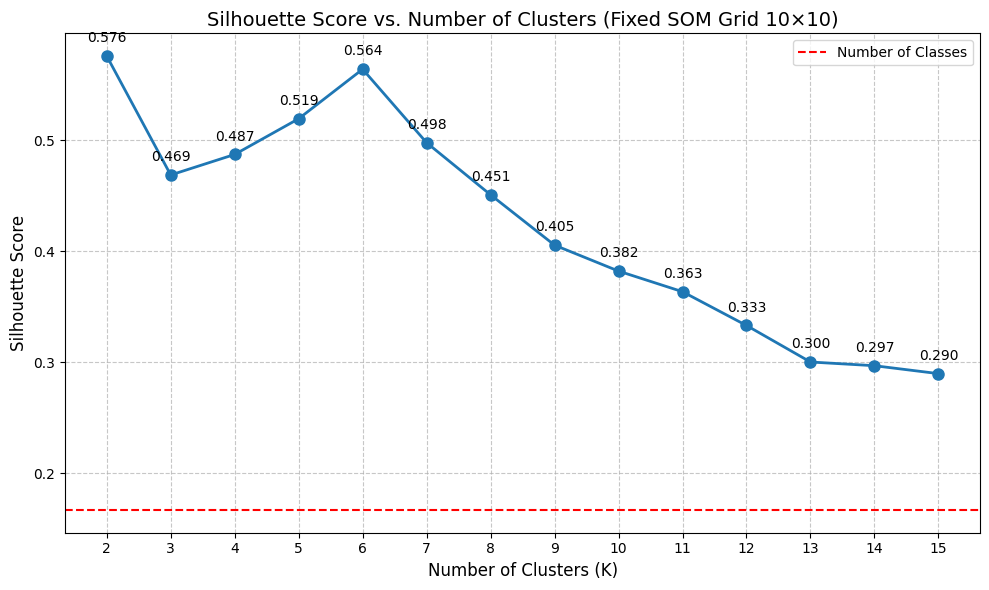


Optimal number of clusters: 2 with silhouette score: 0.576


In [ ]:
unique_classes = len(np.unique(classes))
custom_grid_size = (10, 10)
cluster_sizes, silhouette_scores = analyze_som_clustering(data, max_clusters=15, grid_size=custom_grid_size)

plt.figure(figsize=(10, 6))
plt.plot(cluster_sizes, silhouette_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title(f'Silhouette Score vs. Number of Clusters (Fixed SOM Grid {custom_grid_size[0]}×{custom_grid_size[1]})', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(cluster_sizes)

for i, score in enumerate(silhouette_scores):
    if not np.isnan(score):
        plt.annotate(f'{score:.3f}', 
                   (cluster_sizes[i], score),
                   textcoords="offset points", 
                   xytext=(0, 10), 
                   ha='center')

plt.axhline(y=1/unique_classes, color='r', linestyle='--', label='Number of Classes')
plt.legend()
plt.tight_layout()
plt.show()

valid_scores = [(k, score) for k, score in zip(cluster_sizes, silhouette_scores) if not np.isnan(score)]
if valid_scores:
    best_k, best_score = max(valid_scores, key=lambda x: x[1])
    print(f"\nOptimal number of clusters: {best_k} with silhouette score: {best_score:.3f}")
else:
    print("No valid silhouette scores found")

Trening sieci: 100%|██████████| 100/100 [00:02<00:00, 41.01epoka/s]


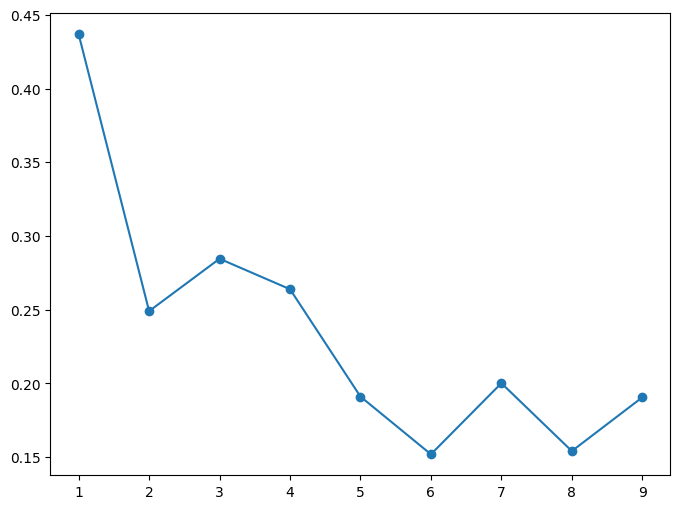

In [8]:
silhoutete_scores = []
for i in range(2, 11):
    som_hex = KohonenNetwork(input_dim=data.shape[1], grid_size=(i, i), 
                              topology='rectangular', neighborhood_function='gaussian')
    som_hex.train(data, epochs=100)
    silhoutete_scores.append(float(som_hex.calculate_silhouette_score(data)['silhouette_score']))

plt.figure(figsize=(8, 6))
plt.plot(range(1, 10), silhoutete_scores, marker='o')

Training SOM with fixed grid size 6x6...


Trening sieci: 100%|██████████| 100/100 [00:09<00:00, 10.11epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.574
Evaluating with 3 clusters...
  Silhouette score: 0.492
Evaluating with 4 clusters...
  Silhouette score: 0.467
Evaluating with 5 clusters...
  Silhouette score: 0.443
Evaluating with 6 clusters...
  Silhouette score: 0.421
Evaluating with 7 clusters...
  Silhouette score: 0.491
Evaluating with 8 clusters...
  Silhouette score: 0.364
Evaluating with 9 clusters...
  Silhouette score: 0.422
Evaluating with 10 clusters...
  Silhouette score: 0.427
Evaluating with 11 clusters...
  Silhouette score: 0.379
Evaluating with 12 clusters...
  Silhouette score: 0.353
Evaluating with 13 clusters...
  Silhouette score: 0.320
Evaluating with 14 clusters...
  Silhouette score: 0.308
Evaluating with 15 clusters...
  Silhouette score: 0.308


NameError: name 'grid_size' is not defined

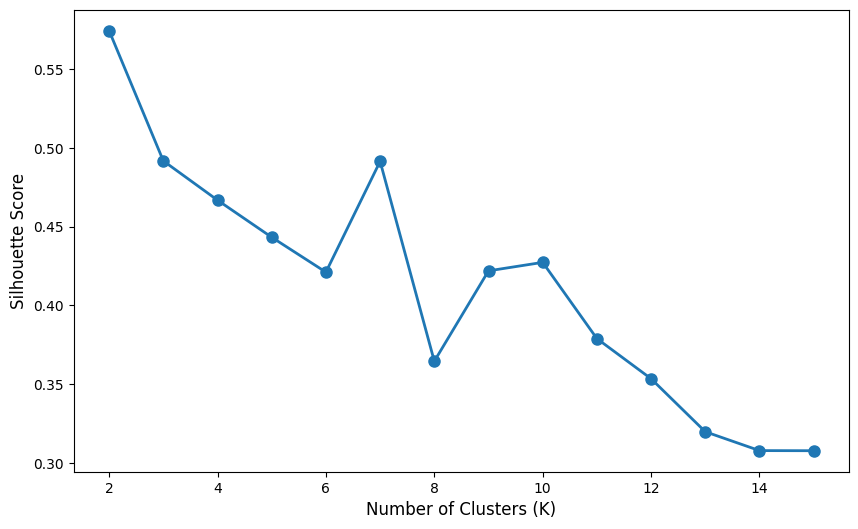

In [9]:
cluster_sizes, silhouette_scores = analyze_som_clustering(data, max_clusters=15, grid_size=(6, 6))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(cluster_sizes, silhouette_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title(f'Silhouette Score vs. Number of Clusters (Fixed SOM Grid {grid_size[0]}×{grid_size[1]})', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(cluster_sizes)

# Add value annotations
for i, score in enumerate(silhouette_scores):
    if not np.isnan(score):  # Only annotate non-NaN values
        plt.annotate(f'{score:.3f}', 
                   (cluster_sizes[i], score),
                   textcoords="offset points", 
                   xytext=(0, 10), 
                   ha='center')

plt.tight_layout()
plt.show()

# Find the optimal number of clusters
valid_scores = [(k, score) for k, score in zip(cluster_sizes, silhouette_scores) if not np.isnan(score)]
if valid_scores:
    best_k, best_score = max(valid_scores, key=lambda x: x[1])
    print(f"\nOptimal number of clusters: {best_k} with silhouette score: {best_score:.3f}")
else:
    print("No valid silhouette scores found")

Training SOM with fixed grid size 8x8...


Trening sieci: 100%|██████████| 100/100 [00:16<00:00,  5.92epoka/s]


Evaluating with 2 clusters...
  Silhouette score: 0.575
Evaluating with 3 clusters...
  Silhouette score: 0.436
Evaluating with 4 clusters...
  Silhouette score: 0.478
Evaluating with 5 clusters...
  Silhouette score: 0.441
Evaluating with 6 clusters...
  Silhouette score: 0.570
Evaluating with 7 clusters...
  Silhouette score: 0.531
Evaluating with 8 clusters...
  Silhouette score: 0.489
Evaluating with 9 clusters...
  Silhouette score: 0.464
Evaluating with 10 clusters...
  Silhouette score: 0.416
Evaluating with 11 clusters...
  Silhouette score: 0.411
Evaluating with 12 clusters...
  Silhouette score: 0.398
Evaluating with 13 clusters...
  Silhouette score: 0.376
Evaluating with 14 clusters...
  Silhouette score: 0.327
Evaluating with 15 clusters...
  Silhouette score: 0.313


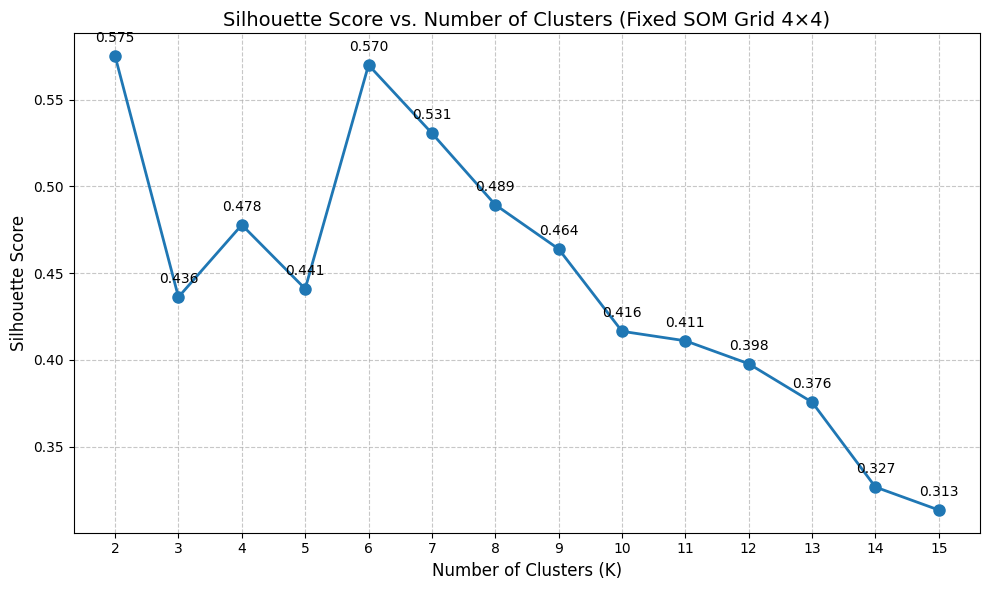


Optimal number of clusters: 2 with silhouette score: 0.575


: 

In [ ]:
cluster_sizes, silhouette_scores = analyze_som_clustering(data, max_clusters=15, grid_size=(8, 8))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(cluster_sizes, silhouette_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title(f'Silhouette Score vs. Number of Clusters (Fixed SOM Grid {grid_size[0]}×{grid_size[1]})', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(cluster_sizes)

# Add value annotations
for i, score in enumerate(silhouette_scores):
    if not np.isnan(score):  # Only annotate non-NaN values
        plt.annotate(f'{score:.3f}', 
                   (cluster_sizes[i], score),
                   textcoords="offset points", 
                   xytext=(0, 10), 
                   ha='center')

plt.tight_layout()
plt.show()

# Find the optimal number of clusters
valid_scores = [(k, score) for k, score in zip(cluster_sizes, silhouette_scores) if not np.isnan(score)]
if valid_scores:
    best_k, best_score = max(valid_scores, key=lambda x: x[1])
    print(f"\nOptimal number of clusters: {best_k} with silhouette score: {best_score:.3f}")
else:
    print("No valid silhouette scores found")

Trening sieci: 100%|██████████| 100/100 [00:24<00:00,  4.07epoka/s]


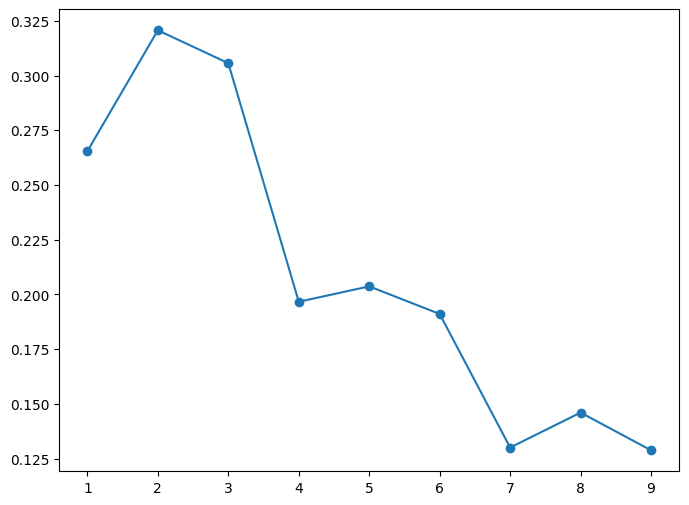

In [86]:
silhoutete_scores = []
for i in range(2, 11):
    som_hex = KohonenNetwork(input_dim=data.shape[1], grid_size=(i, i), 
                              topology='hexagonal', neighborhood_function='gaussian')
    som_hex.train(data, epochs=100)
    silhoutete_scores.append(float(som_hex.calculate_silhouette_score(data)['silhouette_score']))

plt.figure(figsize=(8, 6))
plt.plot(range(1, 10), silhoutete_scores, marker='o')

### KOH 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import pandas as pd
import os
from sklearn.datasets import fetch_openml
# Załaduj zmodyfikowaną klasę KohonenNetwork
# from kohonen_hexagonal import KohonenNetwork, compare_topologies
def load_mnist_data():
    """Załaduj dane MNIST"""
    # Zamiast TensorFlow użyjemy scikit-learn do załadowania MNIST
    mnist = fetch_openml('mnist_784', version=1, parser='auto')
    x_data = mnist.data.to_numpy().astype('float32') / 255.0  # Dodane .to_numpy() aby upewnić się, że dane są w formacie numpy array
    y_train = mnist.target.to_numpy().astype(int)  # Dodane .to_numpy() aby upewnić się, że etykiety są w formacie numpy array
   
    # Wybierz tylko część danych treningowych (odpowiednik oryginalnego x_train)
    x_data = x_data[:6000]
    y_train = y_train[:6000]
   
    # Użyj PCA do redukcji wymiarowości (opcjonalnie)
    pca = PCA(n_components=50)
    x_data_pca = pca.fit_transform(x_data)
   
    return x_data_pca, y_train

def load_har_data():
    """Załaduj dane Human Activity Recognition"""
    # Ten przykład zakłada, że masz pliki w odpowiednich ścieżkach
    # Dostosuj ścieżki do swojej struktury plików
    features_file = 'data/UCI HAR Dataset/train/X_train.txt'
    labels_file = 'data/UCI HAR Dataset/train/y_train.txt'
   
    if os.path.exists(features_file) and os.path.exists(labels_file):
        # Wczytaj dane
        # Poprawiony separator - używamy r przed stringiem aby escape sequence działał poprawnie
        X = pd.read_csv(features_file, sep=r'\s+', header=None)
        y = pd.read_csv(labels_file, header=None).values.ravel()
       
        # Normalizuj dane
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X.values)
       
        return X_scaled, y - 1  # Dostosuj etykiety do 0-based indexing
    else:
        print("Pliki HAR nie zostały znalezione. Użyj odpowiednich ścieżek.")
        return None, None


In [20]:
minist_data, mnist_labels = load_mnist_data()
har_data, har_labels = load_har_data()

In [21]:
print("MNIST data shape:", minist_data.shape)
print("HAR data shape:", har_data.shape)

MNIST data shape: (6000, 50)
HAR data shape: (7352, 561)


# Testing

In [22]:


def analyze_kohonen_results(som, data, labels, title):
    """Analizuj wyniki mapowania na sieci Kohonena"""
    analysis = som.analyze_clustering(data, labels)
    
    print(f"\n=== Analiza: {title} ===")
    print(f"Liczba znalezionych klastrów: {analysis['num_clusters']}")
    print(f"Liczba rzeczywistych klas: {analysis['num_classes']}")
    print(f"Czy klastry odpowiadają klasom: {analysis['clusters_match_classes']}")
    print(f"Procent neuronów z mieszanymi klasami: {analysis['mixed_classes_percentage']:.2%}")
    print(f"Neurony z danymi: {analysis['neurons_with_data']}")
    
    # Analiza czystości neuronów
    if analysis['neuron_stats']:
        purities = [stat['purity'] for stat in analysis['neuron_stats'].values()]
        print(f"Średnia czystość neuronów: {np.mean(purities):.3f}")
        print(f"Maksymalna czystość neuronu: {np.max(purities):.3f}")
        print(f"Minimalna czystość neuronu: {np.min(purities):.3f}")
    
    return analysis

def run_mnist_experiment():
    """Eksperyment z danymi MNIST"""
    print("=== Eksperyment MNIST ===")
    
    # Załaduj dane
    data, labels = load_mnist_data()
    
    # Test z różnymi konfiguracjami
    configs = [
        ('rectangular', 'gaussian'),
        ('rectangular', 'mexican_hat'),
        ('hexagonal', 'gaussian'),
        ('hexagonal', 'mexican_hat')
    ]
    
    results = {}
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, (topology, func) in enumerate(configs):
        title = f"MNIST - {topology} - {func}"
        som = KohonenNetwork(input_dim=data.shape[1], 
                             grid_size=(15, 15),
                             topology=topology, 
                             neighborhood_function=func,
                             neighborhood_width=3.0)
        
        som.train(data[:5000], epochs=100)  # Użyj pierwszych 5000 próbek dla szybkości
        som.visualize_map(data[:5000], labels[:5000], title, axes[i])
        
        results[title] = analyze_kohonen_results(som, data[:5000], labels[:5000], title)
    
    plt.tight_layout()
    plt.show()
    
    return results

def run_har_experiment():
    """Eksperyment z danymi Human Activity Recognition"""
    print("\n=== Eksperyment Human Activity Recognition ===")
    
    # Załaduj dane
    data, labels = load_har_data()
    
    if data is None:
        print("Nie udało się załadować danych HAR")
        return None
    
    # Test z różnymi konfiguracjami
    configs = [
        ('rectangular', 'gaussian'),
        ('rectangular', 'mexican_hat'),
        ('hexagonal', 'gaussian'),
        ('hexagonal', 'mexican_hat')
    ]
    
    results = {}
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, (topology, func) in enumerate(configs):
        title = f"HAR - {topology} - {func}"
        som = KohonenNetwork(input_dim=data.shape[1], 
                             grid_size=(12, 12),
                             topology=topology, 
                             neighborhood_function=func,
                             neighborhood_width=2.0)
        
        som.train(data, epochs=150)
        som.visualize_map(data, labels, title, axes[i])
        
        results[title] = analyze_kohonen_results(som, data, labels, title)
    
    plt.tight_layout()
    plt.show()
    
    return results


=== Eksperyment MNIST ===


Trening sieci: 100%|██████████| 100/100 [00:38<00:00,  2.59epoka/s]
C:\Users\admin\AppData\Local\Temp\ipykernel_11116\1812633390.py:138: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_labels))



=== Analiza: MNIST - rectangular - gaussian ===
Liczba znalezionych klastrów: 2
Liczba rzeczywistych klas: 10
Czy klastry odpowiadają klasom: False
Procent neuronów z mieszanymi klasami: 66.15%
Neurony z danymi: 195
Średnia czystość neuronów: 0.722
Maksymalna czystość neuronu: 1.000
Minimalna czystość neuronu: 0.203


Trening sieci:   0%|          | 0/100 [00:00<?, ?epoka/s]c:\nextcloud\Studia - PW\semestr 6\metody inteligencji obliczeniowej w analizie danych\H-_moje-github_sync-studia-Metody-inteligencji-obliczeniowej-w-analizie-danych\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\admin\AppData\Local\Temp\ipykernel_11116\1812633390.py:83: RuntimeWarning: overflow encountered in square
  distances = np.sum((self.weights - x) ** 2, axis=2)
C:\Users\admin\AppData\Local\Temp\ipykernel_11116\1812633390.py:98: RuntimeWarning: overflow encountered in add
  self.weights += update
C:\Users\admin\AppData\Local\Temp\ipykernel_11116\1812633390.py:98: RuntimeWarning: invalid value encountered in add
  self.weights += update
C:\Users\admin\AppData\Local\Temp\ipykernel_11116\1812633390.py:97: RuntimeWarning: invalid value encountered in multiply
  update = learning_rate * neighborhood[:, :, 


=== Analiza: MNIST - rectangular - mexican_hat ===
Liczba znalezionych klastrów: 1
Liczba rzeczywistych klas: 10
Czy klastry odpowiadają klasom: False
Procent neuronów z mieszanymi klasami: 100.00%
Neurony z danymi: 1
Średnia czystość neuronów: 0.113
Maksymalna czystość neuronu: 0.113
Minimalna czystość neuronu: 0.113


Trening sieci: 100%|██████████| 100/100 [07:44<00:00,  4.64s/epoka]
C:\Users\admin\AppData\Local\Temp\ipykernel_11116\1812633390.py:198: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_labels))



=== Analiza: MNIST - hexagonal - gaussian ===
Liczba znalezionych klastrów: 3
Liczba rzeczywistych klas: 10
Czy klastry odpowiadają klasom: False
Procent neuronów z mieszanymi klasami: 65.10%
Neurony z danymi: 192
Średnia czystość neuronów: 0.735
Maksymalna czystość neuronu: 1.000
Minimalna czystość neuronu: 0.231


Trening sieci: 100%|██████████| 100/100 [07:50<00:00,  4.70s/epoka]



=== Analiza: MNIST - hexagonal - mexican_hat ===
Liczba znalezionych klastrów: 1
Liczba rzeczywistych klas: 10
Czy klastry odpowiadają klasom: False
Procent neuronów z mieszanymi klasami: 100.00%
Neurony z danymi: 1
Średnia czystość neuronów: 0.113
Maksymalna czystość neuronu: 0.113
Minimalna czystość neuronu: 0.113


C:\Users\admin\AppData\Local\Temp\ipykernel_11116\954309345.py:53: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


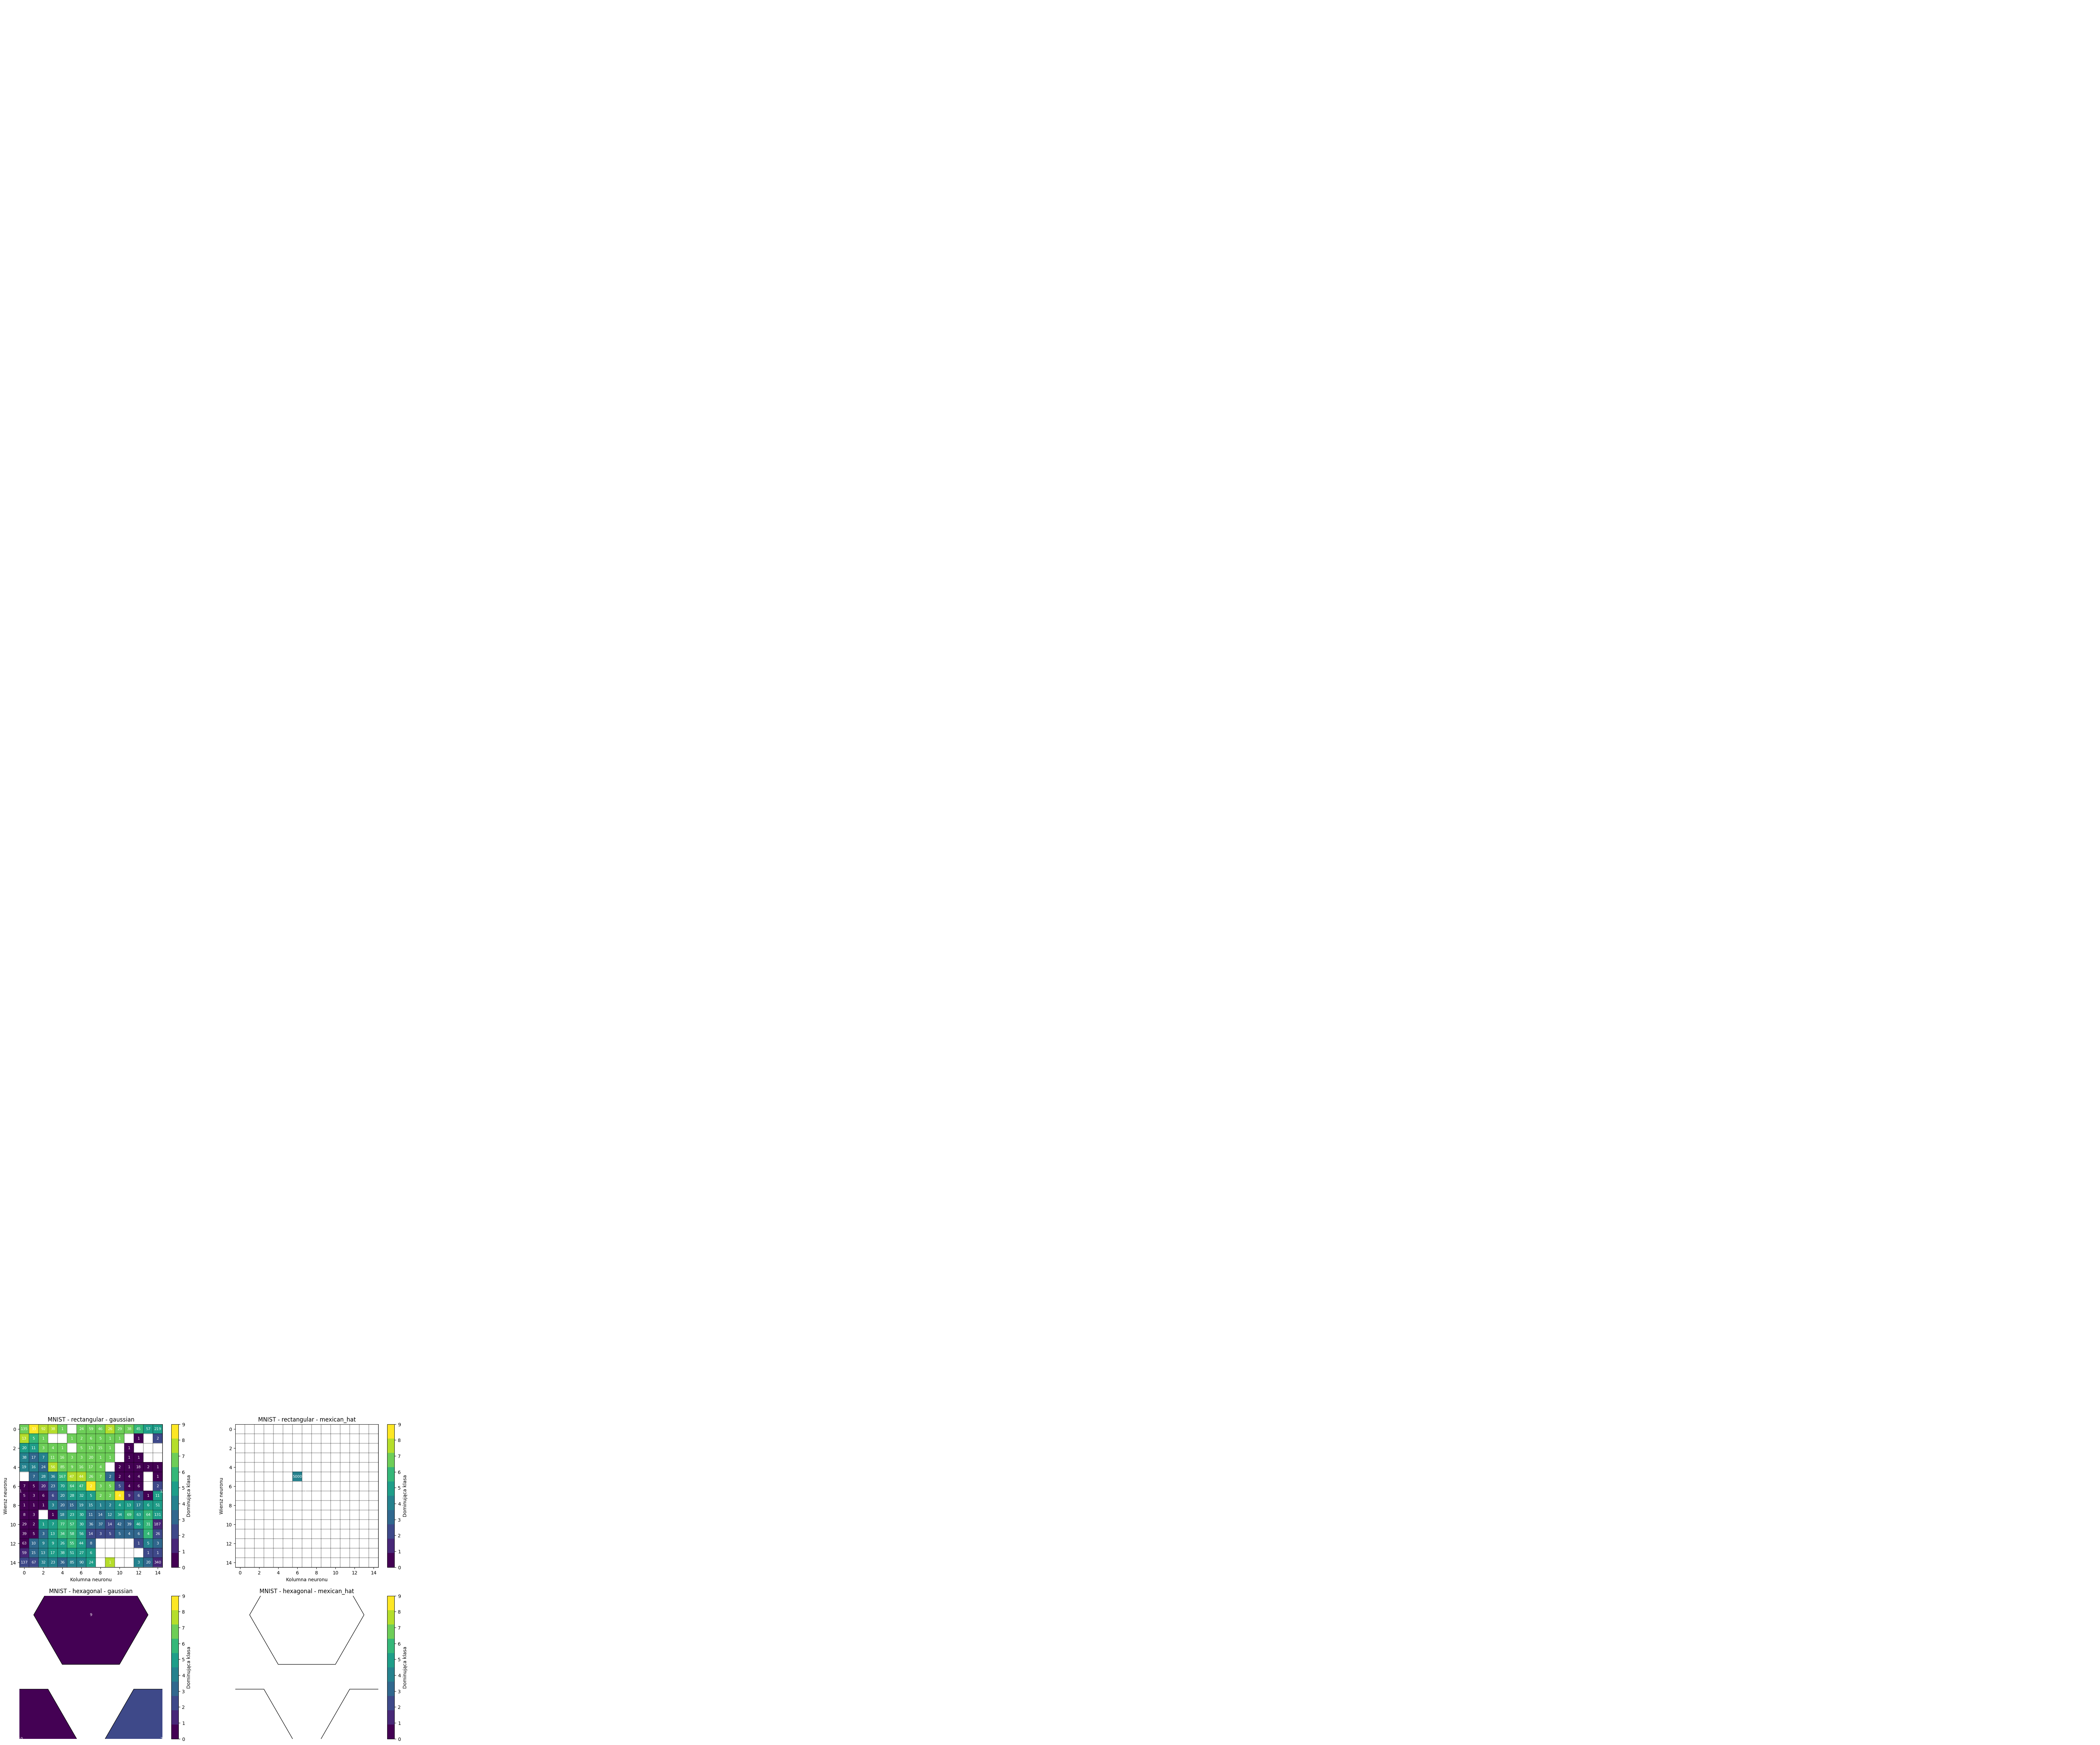

{'MNIST - rectangular - gaussian': {'num_clusters': 2,
  'num_classes': 10,
  'clusters_match_classes': False,
  'neurons_with_mixed_classes': 129,
  'neurons_with_data': 195,
  'mixed_classes_percentage': 0.6615384615384615,
  'class_positions': {np.int64(0): array([10.11482255,  2.74321503]),
   np.int64(1): array([12.06216696, 13.73357016]),
   np.int64(2): array([8.68237705, 7.46311475]),
   np.int64(3): array([10.35496957,  4.59026369]),
   np.int64(4): array([6.94579439, 6.61869159]),
   np.int64(5): array([7.29953917, 6.47926267]),
   np.int64(6): array([7.22754491, 8.21556886]),
   np.int64(7): array([2.75090909, 6.98181818]),
   np.int64(8): array([7.27272727, 4.95887446]),
   np.int64(9): array([5.10707071, 6.4969697 ])},
  'neuron_stats': {(0, 0): {'total_samples': 135,
    'class_counts': {np.int64(0): 1,
     np.int64(1): 1,
     np.int64(2): 0,
     np.int64(3): 19,
     np.int64(4): 0,
     np.int64(5): 17,
     np.int64(6): 0,
     np.int64(7): 1,
     np.int64(8): 93,


In [23]:
run_mnist_experiment()

In [ ]:
def run_mnist_experiment():
    """Eksperyment z danymi MNIST"""
    print("=== Eksperyment MNIST ===")
    
    # Załaduj dane
    data, labels = load_mnist_data()
    
    # Test z różnymi konfiguracjami
    configs = [
        ('rectangular', 'gaussian'),
        ('rectangular', 'mexican_hat'),
        ('hexagonal', 'gaussian'),
        ('hexagonal', 'mexican_hat')
    ]
    
    results = {}
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, (topology, func) in enumerate(configs):
        title = f"MNIST - {topology} - {func}"
        som = KohonenNetwork(input_dim=data.shape[1], 
                             grid_size=(15, 15),
                             topology=topology, 
                             neighborhood_function=func,
                             neighborhood_width=3.0)
        
        som.train(data[:5000], epochs=100)  # Użyj pierwszych 5000 próbek dla szybkości
        som.visualize_map(data[:5000], labels[:5000], title, axes[i])
        
        results[title] = analyze_kohonen_results(som, data[:5000], labels[:5000], title)
    
    plt.tight_layout()
    plt.show()
    
    return results

# 1 at a time

In [42]:
data, labels = load_mnist_data()

In [43]:
data.shape, labels.shape

((6000, 784), (6000,))

In [44]:
data

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
som = KohonenNetwork(input_dim=data.shape[1], grid_size=(10, 10), topology='rectangular', neighborhood_function='gaussian')
som.train(data[:5000], epochs=100)

Trening sieci:   0%|          | 0/100 [00:00<?, ?epoka/s]


KeyError: np.int32(197)

C:\Users\admin\AppData\Local\Temp\ipykernel_11116\1812633390.py:138: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_labels))


<Axes: title={'center': 'MNIST - Rectangular - Gaussian'}, xlabel='Kolumna neuronu', ylabel='Wiersz neuronu'>

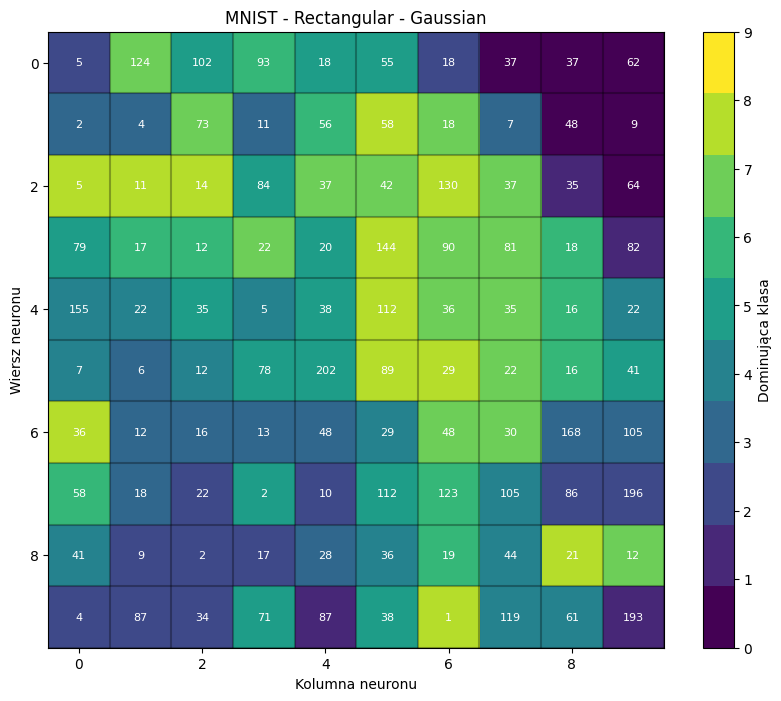

In [31]:
som.visualize_map(data[:5000], labels[:5000], "MNIST - Rectangular - Gaussian")

## Efect of neighborhood width on classification

Trening sieci: 100%|██████████| 100/100 [00:27<00:00,  3.70epoka/s]
C:\Users\admin\AppData\Local\Temp\ipykernel_11116\1812633390.py:138: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_labels))
Trening sieci: 100%|██████████| 100/100 [00:27<00:00,  3.58epoka/s]


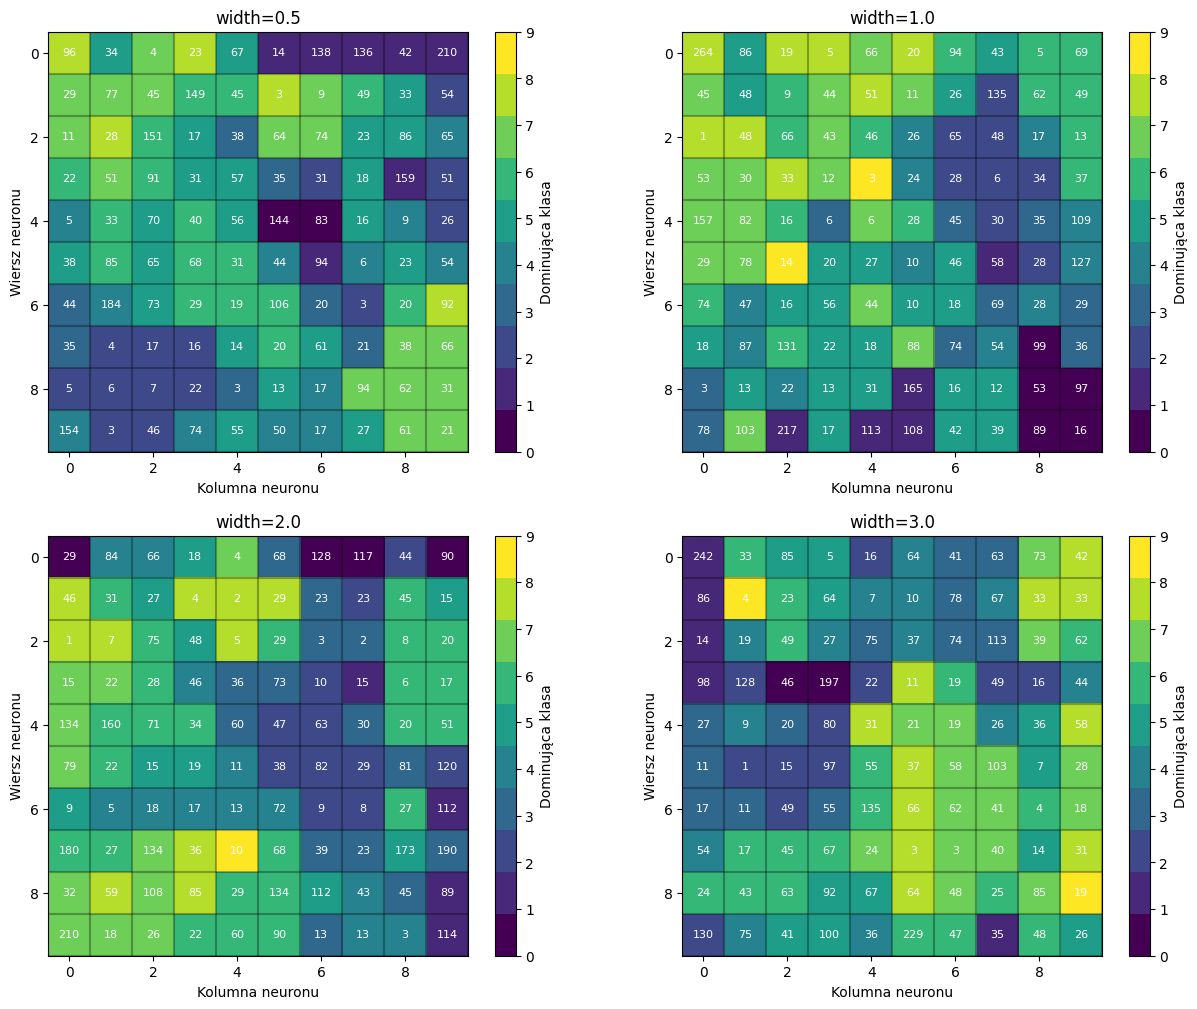

In [32]:
neighborhood_widths = [0.5, 1.0, 2.0, 3.0]
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
networks = []
for i, width in enumerate(neighborhood_widths):

    som = KohonenNetwork(input_dim=data.shape[1], grid_size=(10, 10), topology='rectangular', neighborhood_function='gaussian')
    som.train(data[:5000], epochs=100)
    som.visualize_map(data[:5000], labels[:5000], f"MNIST - Rectangular - Gaussian (width={width})", axes[i//2, i%2])
    axes[i//2, i%2].set_title(f"width={width}")
    networks.append(som)

C:\Users\admin\AppData\Local\Temp\ipykernel_11116\2608902729.py:269: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_labels))


<Axes: title={'center': 'MNIST - Rectangular - Gaussian'}>

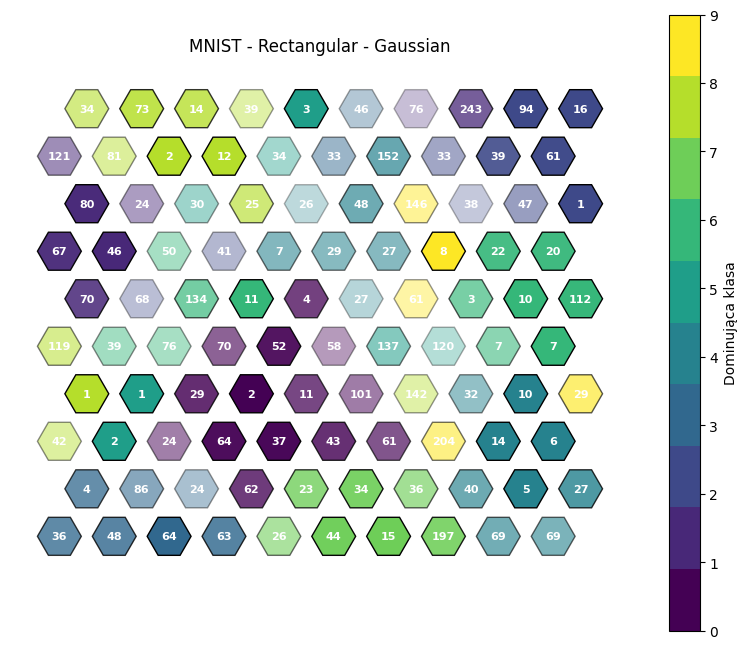

In [58]:
som.visualize_map(data[:5000], labels[:5000], "MNIST - Rectangular - Gaussian")

In [63]:
som.analyze_clustering(data[:5000], labels[:5000])

{'num_clusters': 1,
 'num_classes': 10,
 'clusters_match_classes': False,
 'neurons_with_mixed_classes': 79,
 'neurons_with_data': 100,
 'mixed_classes_percentage': 0.79,
 'class_positions': {np.int64(0): array([2.36484599, 4.03340292]),
  np.int64(1): array([6.34059807, 3.07282416]),
  np.int64(2): array([6.0568539 , 6.36577869]),
  np.int64(3): array([2.59456292, 2.89959432]),
  np.int64(4): array([3.9481046 , 6.68130841]),
  np.int64(5): array([3.61376038, 3.89746544]),
  np.int64(6): array([4.40099936, 5.11576846]),
  np.int64(7): array([1.55727114, 6.26818182]),
  np.int64(8): array([5.29737617, 3.03246753]),
  np.int64(9): array([3.78076949, 6.51212121])},
 'neuron_stats': {(0, 0): {'total_samples': 36,
   'class_counts': {np.int64(0): 0,
    np.int64(1): 0,
    np.int64(2): 1,
    np.int64(3): 28,
    np.int64(4): 0,
    np.int64(5): 5,
    np.int64(6): 0,
    np.int64(7): 0,
    np.int64(8): 1,
    np.int64(9): 1},
   'dominant_class': np.int64(3),
   'purity': 0.77777777777777

## HEX

In [53]:
som = KohonenNetwork(input_dim=data.shape[1], grid_size=(10, 10), topology='hexagonal', neighborhood_function='gaussian')
som.train(data[:5000], epochs=100)

Trening sieci:   0%|          | 0/100 [00:00<?, ?epoka/s]


KeyError: np.int32(1735)

Trening sieci: 100%|██████████| 100/100 [03:37<00:00,  2.17s/epoka]
C:\Users\admin\AppData\Local\Temp\ipykernel_11116\3602183547.py:213: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_labels))


<Figure size 1200x1000 with 0 Axes>

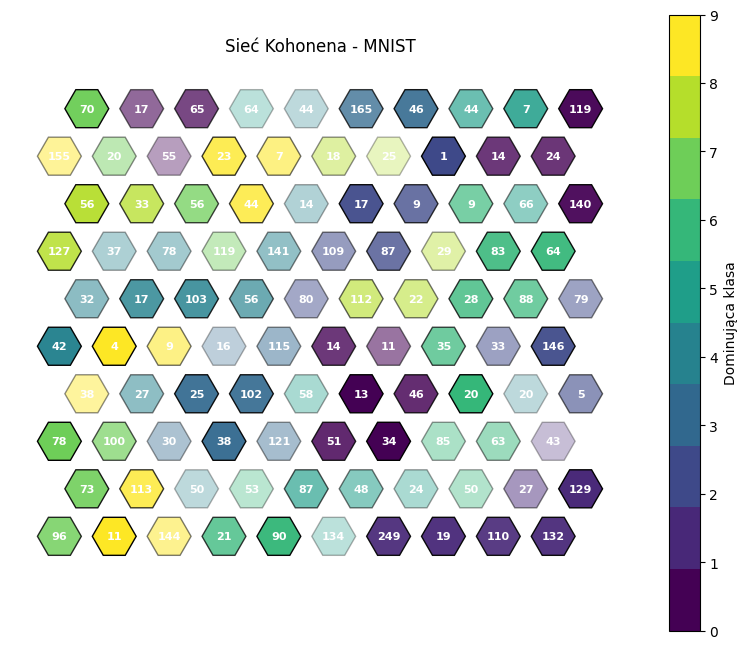

Liczba klastrów: 1
Liczba klas: 10
Procent neuronów z mieszanymi klasami: 0.93


In [54]:
x_data, y_train = load_mnist_data()
    
# Utwórz i trenuj sieć Kohonena
# Upewnij się, że dane są w odpowiednim formacie
som = KohonenNetwork(input_dim=x_data.shape[1], grid_size=(10, 10), 
                        topology='hexagonal', neighborhood_function='gaussian')

# Ogranicz liczbę próbek do treningu, jeśli to konieczne
num_samples = min(5000, x_data.shape[0])
training_data = x_data[:num_samples].copy()  # Użyj .copy() aby uniknąć problemów z widokiem danych

# Trening sieci
som.train(training_data, epochs=100)

# Wizualizacja wyników
plt.figure(figsize=(12, 10))
som.visualize_map(x_data, y_train, "Sieć Kohonena - MNIST")
plt.show()

# Analiza klastrowania
analysis = som.analyze_clustering(x_data, y_train)
print(f"Liczba klastrów: {analysis['num_clusters']}")
print(f"Liczba klas: {analysis['num_classes']}")
print(f"Procent neuronów z mieszanymi klasami: {analysis['mixed_classes_percentage']:.2f}")
